# Regression with simulated dataset

Sensitivity analysis using GLM package.

In [1]:
using DataFrames
using CSV
using GLM
using CairoMakie
using LaTeXStrings
using Statistics
using StatsBase
using Distributions
using LinearAlgebra
using RegressionTables

## Load and preprocess data

In [2]:
dirname = "sim-dataset"
data = CSV.read("$dirname/$dirname-numpass-data.csv", DataFrame)
println("$(nrow(data)) samples originally")
#describe(data)
numtrial = only(unique(data[!, :numtrial]))
println("$numtrial games for each set of parameter values.")

15000 samples originally
500 games for each set of parameter values.


In [3]:
# thresholds for preprocessing
th_np = 1 # < passcount_mean
th_ma = 18  # >= mean of area
th_bout = 400  # > frequency of ball_out

400

In [4]:
# exclude outliers
data = subset(
    data, 
    :passcount_mean => np -> np .>= th_np,
    :ball_out => bo -> bo .< th_bout,
)
datasize = nrow(data)
println("$(datasize) samples after preprocessing")
describe(data)

14105 samples after preprocessing


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,seed,7517.92,1,7523.0,15000,0,Int64
2,passcount_mean,8.37948,1.0,7.356,20.0,0,Float64
3,passcount_var,29.3126,0.0,30.321,71.4152,0,Float64
4,passwide_freq,0.834219,0.52189,0.852984,1.0,0,Float64
5,avearea_mean,11.3848,3.91655,11.7145,17.7917,0,Float64
6,vararea_mean,1.34643,0.0572001,0.994787,17.094,0,Float64
7,intercept,289.908,0,310.0,500,0,Int64
8,max_pass,107.244,0,44.0,500,0,Int64
9,ball_out,102.848,0,59.0,399,0,Int64


## Regression

In [5]:
# significance level
α = 1e-3

0.001

### Utilities

In [6]:
# columns of parameters and simulation results
col_params = [
    :m, :T, :σ, :β, :kr, :γ, :kf, :Lf, :ke, :Le, :q, :τ, :L_ict
]
col_res = [
    :passcount_mean, :passcount_var, :passwide_freq, :avearea_mean,
    :vararea_mean, :intercept, :max_pass, :ball_out,
]
# labels of parameters
d_paramlab = Dict(
    :m => L"m", :T => L"T", :σ => L"σ", :β => L"β", :kr => L"k_\mathrm{r}",
    :γ => L"γ", :kf => L"k_\mathrm{f}", :Lf => L"L_\mathrm{f}",
    :ke => L"k_\mathrm{e}", :Le => L"L_\mathrm{e}", :q => L"q",
    :τ => L"τ", :L_ict => L"L_\mathrm{ict}",
);

In [7]:
""" Summarize relevant information about the regrassion model """
function diagnose_fit(fitmod, name)
    # export regression table
    write("$(name)-reg-table.txt", string(fitmod))
    # evaluate the fit
    round4(val) = round(val, digits=4)
    println("adjested R^2: $(round4(adjr2(fitmod)))")
    println("AIC: $(round4(aic(fitmod)));\t BIC: $(round4(bic(fitmod)))")
    # normality of residuals
    gaussfit = fit(Normal, residuals(fitmod))  # gaussian fit for residuals
    # plot residuals
    f = Figure(size=(400, 300))
    ax, h = hist(f[2, 1], 
        residuals(fitmod), bins=30, color=:lightgray, strokewidth=1, 
        normalization=:pdf
    )
    ax.xlabel = "residuals"
    ax.ylabel = "prob. density"
    resval = range(minimum(residuals(ols_lin)), maximum(residuals(ols_lin)), 100)
    lines!(
        ax, resval, pdf(gaussfit, resval), color=:black, linewidth=2, 
        label="μ = $(round(gaussfit.μ, digits=3)), σ = $(round(gaussfit.σ, digits=3))"
    )
    Legend(f[1, 1], ax, tellheight=true)
    colsize!(f.layout, 1, Relative(1))
    return(f)
end

diagnose_fit

In [8]:
find_minmax(df, colname) = (
    minimum(df[!, colname]), maximum(df[!, colname])
)

find_minmax (generic function with 1 method)

In [9]:
""" Show influence of model parameters """
function plot_param_influence(data, d_x, d_pred, α, ncol::Int)
    datasize = size(data, 1)
    nrow::Int64 = ceil(length(d_pred) / ncol)
    panelsize = 700 / ncol

    f = Figure(size=(panelsize * ncol, panelsize * nrow))
    i = 0
    for key in col_params
        if !(key in keys(d_pred)) continue end

        irow, jcol = (i ÷ ncol, i % ncol)
        @debug println(irow, "\t", jcol)
        d_axissetting = Dict{Symbol, Any}(
            #:title => d_paramlab[key], 
            #:titlesize => 20,
            :xlabel => d_paramlab[key]
        )
        if jcol == 0
            d_axissetting[:ylabel] = "effect on #passes"
        elseif jcol != 0
            d_axissetting[:yticksvisible] = false
            d_axissetting[:yticklabelsvisible] = false
        end
        ax = Axis(f[irow, jcol]; d_axissetting...)
        # plot prediction against de-centered x axis
        lines!(ax, d_x[key] .+ mean(data[:, key]), d_pred[key], color=:black)

        i += 1
    end
    linkyaxes!(f.content...)  # link y axis among all axes
    Label(
        f[nrow, :], 
        latexstring("$datasize samples, \$p < $(α)\$"), 
        fontsize=12, halign=:right
    )
    return f
end

plot_param_influence

### Preprocessing

#### extract relevant columns

In [10]:
# extract relevant columns
df_anal = data[:, [col_params..., col_res...]]
println(size(df_anal))

(14105, 21)


#### Center the data around 0

In [11]:
df_cent = mapcols(x -> x .- mean(x), df_anal, cols=col_params)
describe(df_cent)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,m,7.66913e-15,-9.9989,-0.0426931,10.0004,0,Float64
2,T,7.48072e-17,-0.34904,-0.00157072,0.350913,0,Float64
3,σ,-8.91642e-16,-3.00424,-0.00835272,2.99517,0,Float64
4,β,1.03168e-15,-12.4829,0.105875,12.5125,0,Float64
5,kr,1.36698e-14,-511.934,2.27859,487.969,0,Float64
6,γ,-2.45025e-15,-502.044,-0.851457,497.87,0,Float64
7,kf,-2.96609e-15,-100.277,0.793375,99.7131,0,Float64
8,Lf,1.23117e-15,-2.46959,-0.0322422,2.53019,0,Float64
9,ke,1.3025e-14,-99.1089,-0.44103,100.811,0,Float64


In [12]:
sumterms = sum(Term.(col_params));
sumsqterms = sum([Term(p) & Term(p) for p in col_params]);

### Perform regression analyses

#### Linear model (OLS)

adjested R^2: 0.7577
AIC: 66642.3234;	 BIC: 66755.6377


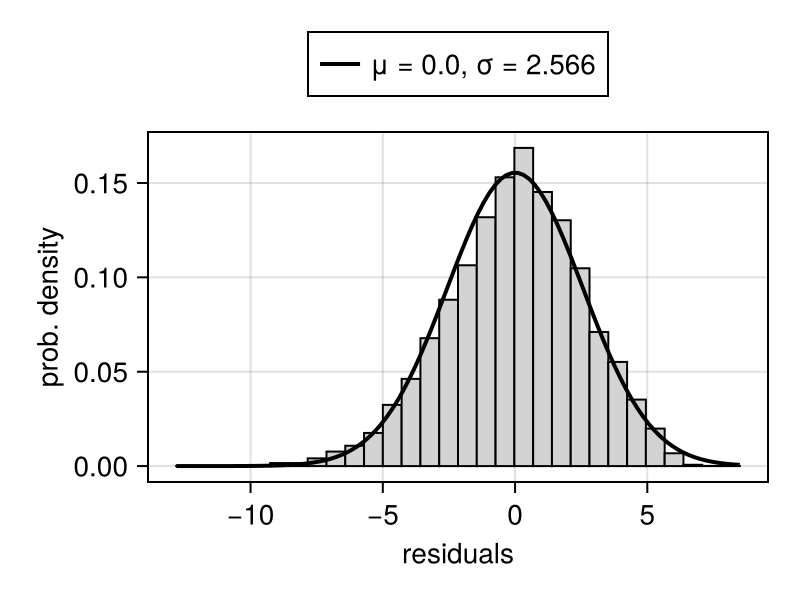

In [13]:
ols_lin = lm(term(:passcount_mean) ~ sumterms, df_cent)
diagnose_fit(ols_lin, "linear")

Visualize significant effects of parameters.

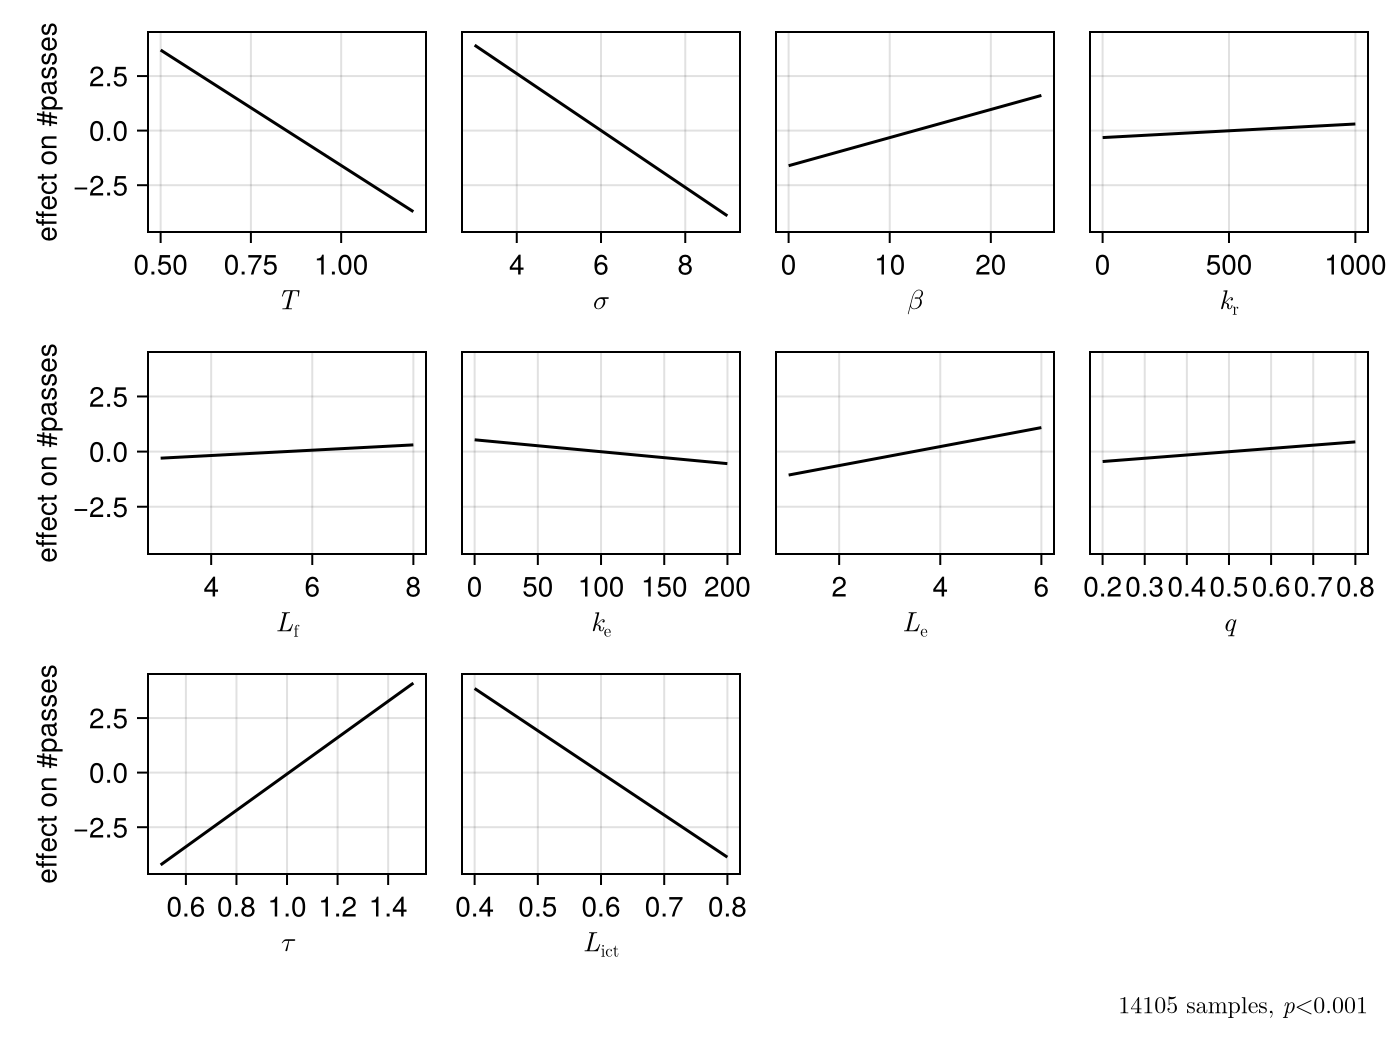

In [14]:
let fitmod = ols_lin
    # code for linear model
    ctcols = coeftable(fitmod).cols

    d_x = Dict()
    d_pred = Dict()
    for (i, par) in enumerate(col_params)
        j = i + 1  # the first column in coeftable is intercept
        if ctcols[4][j] < α
            xmin, xmax = find_minmax(df_cent, par)
            d_x[par] = collect(range(xmin, xmax, 100))
            d_pred[par] = coef(fitmod)[j] * d_x[par]
        end
    end

    f = plot_param_influence(df_anal, d_x, d_pred, α, 4)
    #save("$dirname-ols_lin-parameffect.pdf", f)
    f
end

### Square model
linear terms + square terms; no interaction terms

adjested R^2: 0.7997
AIC: 63969.8057;	 BIC: 64181.3257


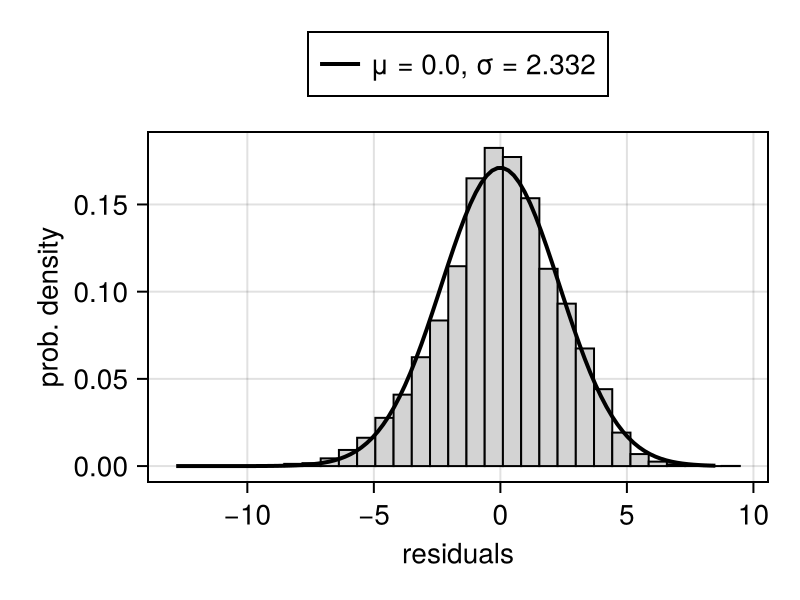

In [15]:
ols_sq = lm(term(:passcount_mean) ~ sumterms + sumsqterms, df_cent)
diagnose_fit(ols_sq, "square")

Visualize significant effects of parameters.

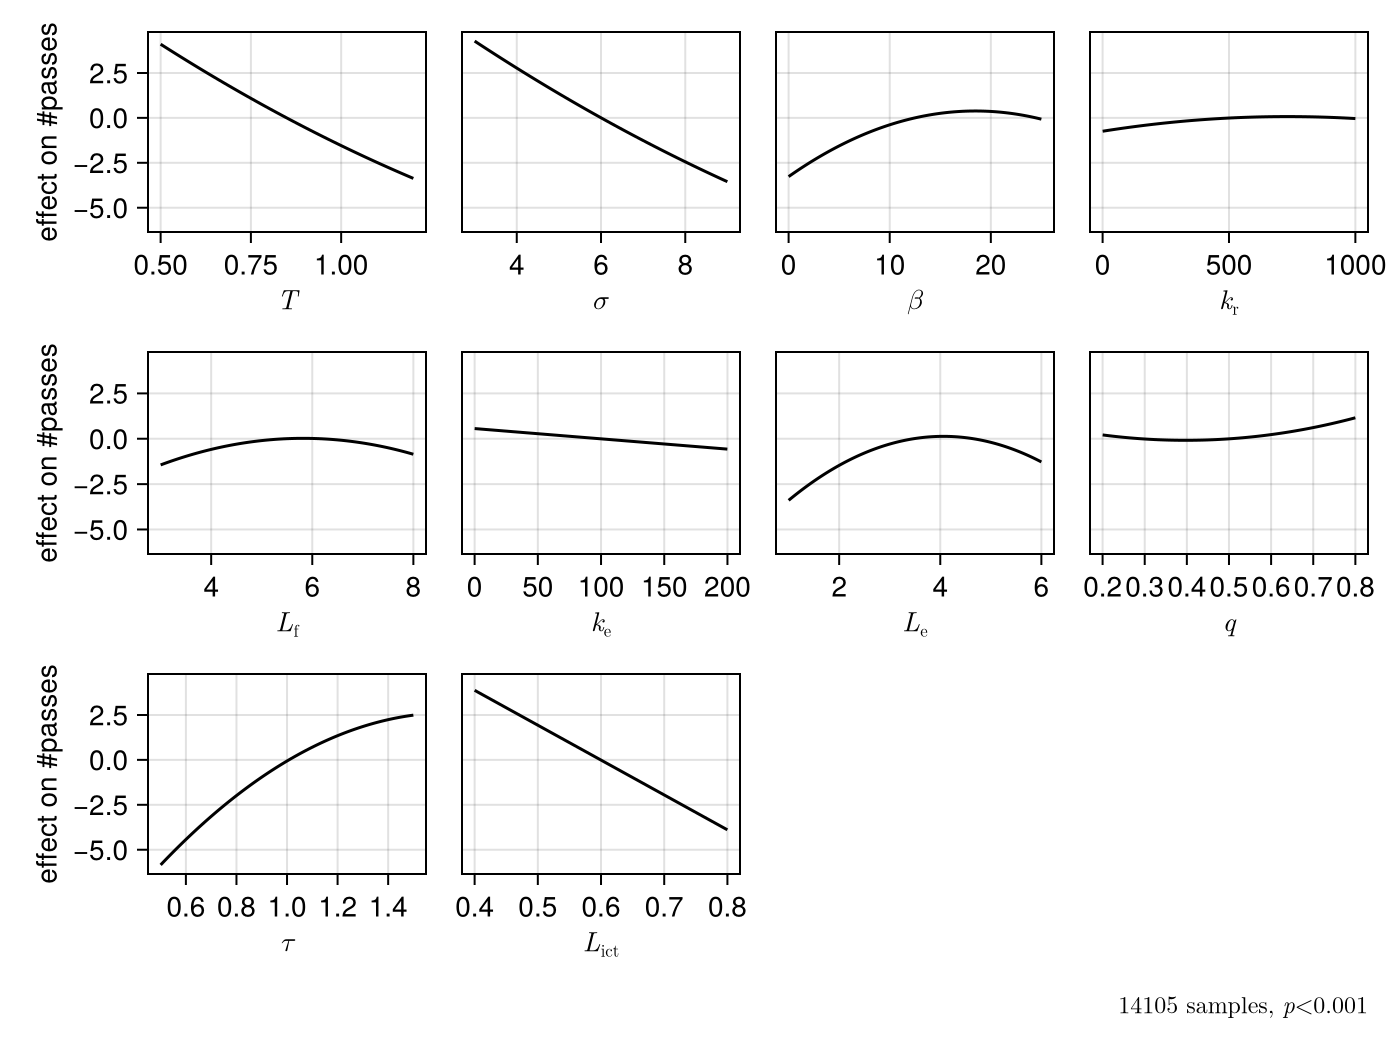

In [16]:
let fitmod = ols_sq
    # code for the model w/ square terms
    strterms = string.(fitmod.mf.f.rhs.terms)
    ctcols = coeftable(fitmod).cols

    d_x = Dict()
    d_pred = Dict()
    for (i, par) in enumerate(col_params)
        j = i + 1  # the first column in coeftable is intercept
        signif = false  # flag for significance
        if ctcols[4][j] < α
            signif = true
            xmin, xmax = find_minmax(df_cent, par)
            d_x[par] = collect(range(xmin, xmax, 100))
            d_pred[par] = coef(fitmod)[j] * d_x[par]
        end
        # find index for square term of the current parameter
        id_parsq = findfirst(isequal("$par & $par"), strterms)
        if ctcols[4][id_parsq] < α
            if signif
                # linear term was also significant
                d_pred[par] .+= coef(fitmod)[id_parsq] * d_x[par].^2
            else
                # linear term was not significant
                signif = true
                xmin, xmax = find_minmax(df_cent, par)
                d_x[par] = collect(range(xmin, xmax, 100))
                d_pred[par] = coef(fitmod)[id_parsq] * d_x[par].^2
            end
        end
    end

    f = plot_param_influence(df_anal, d_x, d_pred, α, 4)
    #save("$dirname-ols_sq-parameffect.pdf", f)
    f
end

Compare linear & square models by F test.

In [17]:
ftest(ols_lin.model, ols_sq.model)

F-test: 2 models fitted on 14105 observations
─────────────────────────────────────────────────────────────────────────
     DOF  ΔDOF         SSR         ΔSSR      R²     ΔR²        F*   p(>F)
─────────────────────────────────────────────────────────────────────────
[1]   15        92875.1253               0.7580                          
[2]   28    13  76702.8956  -16172.2298  0.8001  0.0421  228.3262  <1e-99
─────────────────────────────────────────────────────────────────────────

#### Quadratic model with interaction terms

In [18]:
# standardize data
df_stan = mapcols(x -> (x .- mean(x)) / std(x), df_anal, cols=col_params)
describe(df_stan)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,m,1.33091e-15,-1.73167,-0.00739388,1.73194,0,Float64
2,T,3.89904e-16,-1.72549,-0.00776487,1.73475,0,Float64
3,σ,-5.17354e-16,-1.73518,-0.00482435,1.72995,0,Float64
4,β,1.42058e-16,-1.7257,0.0146367,1.72979,0,Float64
5,kr,3.82852e-17,-1.79691,0.00799795,1.71279,0,Float64
6,γ,5.03752e-19,-1.74888,-0.00296606,1.73434,0,Float64
7,kf,-5.23902e-17,-1.73685,0.0137416,1.72708,0,Float64
8,Lf,8.51845e-16,-1.70997,-0.0223249,1.75193,0,Float64
9,ke,2.21651e-16,-1.71868,-0.00764802,1.74819,0,Float64


In [19]:
sumintterms = sum(reduce(vcat, [
    [Term(col_params[i]) & Term(col_params[j]) 
        for i in 1:length(col_params) if i > j] for j in 1:length(col_params)
    ]
));

adjested R^2: 0.8813
AIC: 56669.9435;	 BIC: 57470.6977


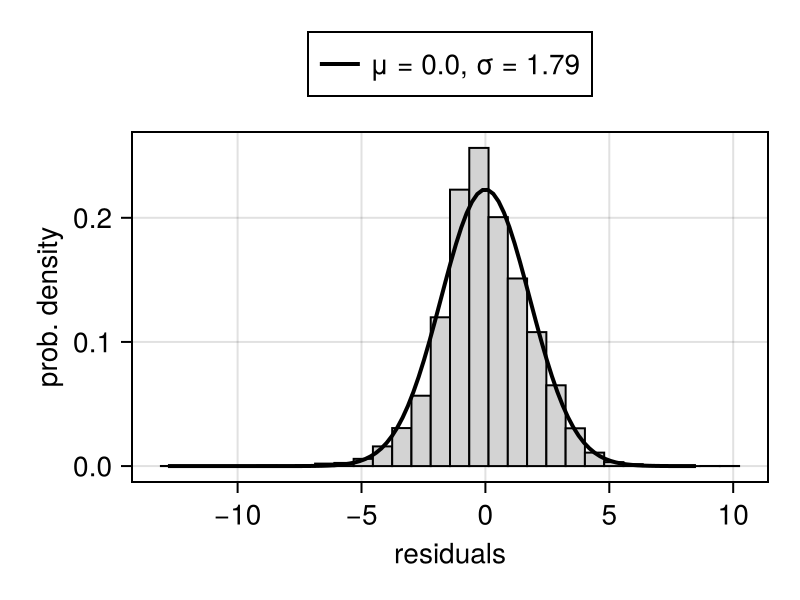

In [20]:
ols_qua = lm(term(:passcount_mean) ~ sumterms + sumsqterms + sumintterms, df_stan)
diagnose_fit(ols_qua, "quadratic")

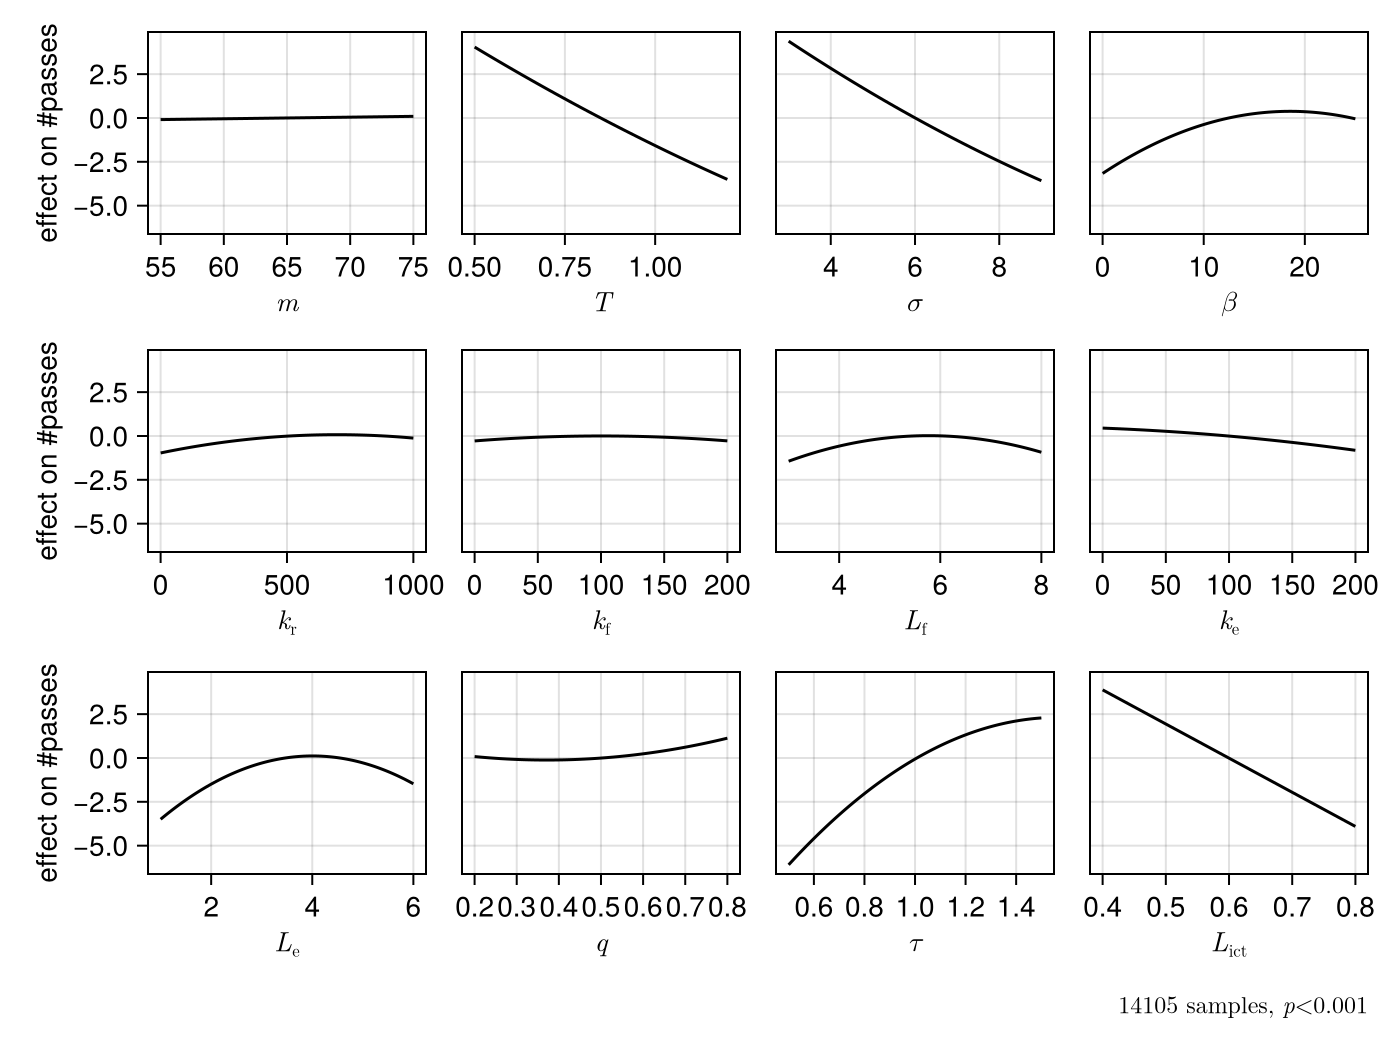

In [21]:
let fitmod = ols_qua
    # code for the quardratic model
    strterms = string.(fitmod.mf.f.rhs.terms)
    ctcols = coeftable(fitmod).cols

    d_x = Dict()
    d_pred = Dict()
    for (i, par) in enumerate(col_params)
        j = i + 1  # the first column in coeftable is intercept
        signif = false  # flag for significance
        if ctcols[4][j] < α
            signif = true
            xmin, xmax = find_minmax(df_stan, par)
            d_x[par] = collect(range(xmin, xmax, 100))
            d_pred[par] = coef(fitmod)[j] * d_x[par]
        end
        # find index for square term of the current parameter
        id_parsq = findfirst(isequal("$par & $par"), strterms)
        if ctcols[4][id_parsq] < α
            if signif
                # linear term was also significant
                d_pred[par] .+= coef(fitmod)[id_parsq] * d_x[par].^2
            else
                # linear term was not significant
                signif = true
                xmin, xmax = find_minmax(df_stan, par)
                d_x[par] = collect(range(xmin, xmax, 100))
                d_pred[par] = coef(fitmod)[id_parsq] * d_x[par].^2
            end
        end
    end

    ncol::Int64 = 4
    nrow::Int64 = ceil(length(d_pred) / ncol)
    panelsize = 700 / ncol

    f = Figure(size=(panelsize * ncol, panelsize * nrow))
    i = 0
    for key in col_params
        if !(key in keys(d_pred)) continue end

        irow, jcol = (i ÷ ncol + 1, i % ncol)
        @debug println(irow, "\t", jcol)
        d_axissetting = Dict{Symbol, Any}(
            #:title => d_paramlab[key], 
            #:titlesize => 20,
            :xlabel => d_paramlab[key]
        )
        if jcol == 0
            d_axissetting[:ylabel] = "effect on #passes"
        elseif jcol != 0
            d_axissetting[:yticksvisible] = false
            d_axissetting[:yticklabelsvisible] = false
        end
        ax = Axis(f[irow, jcol]; d_axissetting...)
        # plot prediction against de-centered x axis
        lines!(
            ax, 
            d_x[key] * std(df_anal[!, key]) .+ mean(df_anal[!, key]), d_pred[key], 
            color=:black
        )

        i += 1
    end
    linkyaxes!(f.content...)  # link y axis among all axes
    #Label(f[0, :], "quadratic effect of each parameter", fontsize=20)
    Label(
        f[nrow + 1, :], 
        latexstring("$datasize samples, \$p < $(α)\$"), 
        fontsize=12, halign=:right
    )
    
    save("$dirname-ols_qua-parameffect.pdf", f)
    f
end

Visualize interaction effects.

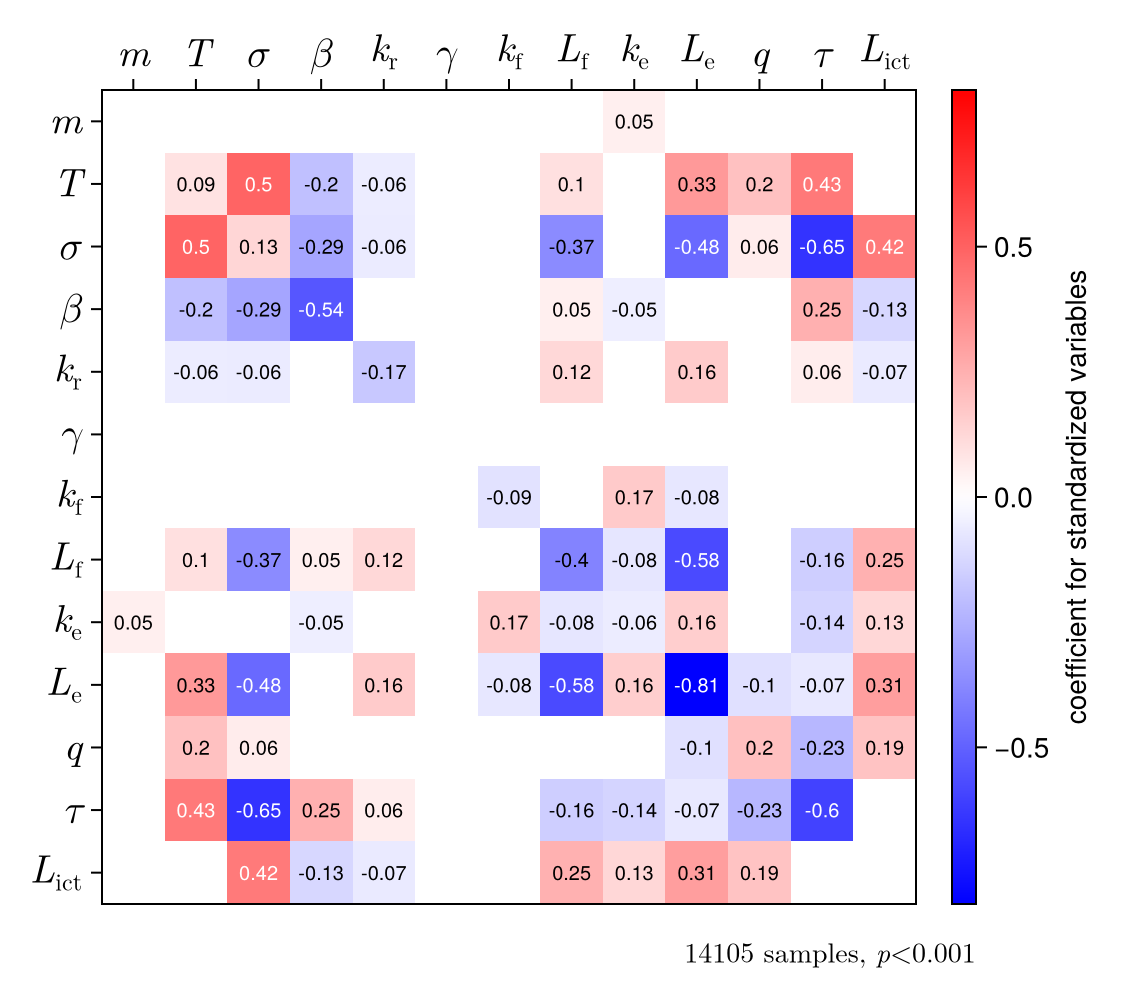

In [22]:
# plot coefficients
let fitmod = ols_qua    
    # code for the quardratic model
    strterms = string.(fitmod.mf.f.rhs.terms)
    ctcols = coeftable(fitmod).cols

    mat_coef = fill(NaN, (length(col_params), length(col_params)))

    for (j, parx) in enumerate(col_params)
        for (i, pary) in enumerate(col_params)
            if i > j break end
            # find index for interaction term of the current parameter
            id_parint = findfirst(
                s -> isequal(s, "$pary & $parx") || isequal(s, "$parx & $pary"), 
                strterms
            )

            if ctcols[4][id_parint] < α
                mat_coef[i, j] = coef(fitmod)[id_parint]
                mat_coef[j, i] = coef(fitmod)[id_parint]
            end
        end
    end

    vec_coef = [el for el in vcat(mat_coef...) if !(isnan(el))]
    cmin, cmax = minimum(vec_coef), maximum(vec_coef)
    clim = maximum(abs.([cmin, cmax]))

    f = Figure(size=(600, 500), dpi=300)
    xyticks = (1:length(col_params), [d_paramlab[key] for key in col_params])
    ax = Axis(
        f[1, 1], xaxisposition=:top, yreversed=true, 
        xticks=xyticks, yticks=xyticks, xticklabelsize=20, yticklabelsize=20,
        xgridvisible=false, ygridvisible=false,
    )
    hm = heatmap!(ax, mat_coef, colormap=:bwr, colorrange=(-clim, clim), nan_color=:white)
    label = [isnan(el) ? "" : string(round(el, digits=2)) for el in vcat(mat_coef...)]
    text!(
        ax, label,
        position=[Point2f(x, y) for x in 1:length(col_params) for y in 1:length(col_params)],
        color=ifelse.(-clim / 2 .< vcat(mat_coef...) .< clim / 2, :black, :white),
        align=(:center, :center), fontsize=10,
    )

    Colorbar(f[1, 2], hm, label="coefficient for standardized variables")

    colsize!(f.layout, 1, Aspect(1, 1))

    #Label(f[1, :], "Interaction effects among parameters", fontsize=20)
    Label(
        f[2, :],
        latexstring("$datasize samples, \$p < $(α)\$"),
        fontsize=14, halign=:right,
    )
    resize_to_layout!(f)
    
    save("$dirname-ols_qua-interaction.pdf", f)
    f
end

#### Compare linear, square, and quardratic models

AIC and BIC

In [23]:
round4(val) = round(val, digits=4)
for (lab, fitmod) in zip(("linear", "square", "quadratic"), (ols_lin, ols_sq, ols_qua))
    println("$lab model:")
    println("\t adjested R^2: $(round4(adjr2(fitmod)))")
    println("\t AIC: $(round4(aic(fitmod)));\t BIC: $(round4(bic(fitmod)))")
end

linear model:
	 adjested R^2: 0.7577
	 AIC: 66642.3234;	 BIC: 66755.6377
square model:
	 adjested R^2: 0.7997
	 AIC: 63969.8057;	 BIC: 64181.3257
quadratic model:
	 adjested R^2: 0.8813
	 AIC: 56669.9435;	 BIC: 57470.6977


F test

In [24]:
ftest(ols_lin.model, ols_sq.model, ols_qua.model)

F-test: 3 models fitted on 14105 observations
─────────────────────────────────────────────────────────────────────────
     DOF  ΔDOF         SSR         ΔSSR      R²     ΔR²        F*   p(>F)
─────────────────────────────────────────────────────────────────────────
[1]   15        92875.1253               0.7580                          
[2]   28    13  76702.8956  -16172.2298  0.8001  0.0421  228.3262  <1e-99
[3]  106    78  45211.0873  -31491.8082  0.8822  0.0821  125.0219  <1e-99
─────────────────────────────────────────────────────────────────────────

### Export regression table

In [25]:
regtable(
    ols_lin, ols_sq, ols_qua; 
    render=LatexTable(), file="$dirname-regtab.tex"
)

\begin{tabular}{lrrr}
\toprule
                       &  \multicolumn{3}{c}{passcount\_mean} \\ 
\cmidrule(lr){2-4} 
                       &        (1) &        (2) &        (3) \\ 
\midrule
(Intercept)            &   8.379*** &  10.334*** &  10.565*** \\ 
                       &    (0.022) &    (0.082) &    (0.063) \\ 
m                      &    0.011** &     0.008* &   0.053*** \\ 
                       &    (0.004) &    (0.003) &    (0.015) \\ 
T                      & -10.575*** & -10.678*** &  -2.181*** \\ 
                       &    (0.107) &    (0.097) &    (0.015) \\ 
σ                      &  -1.303*** &  -1.304*** &  -2.295*** \\ 
                       &    (0.012) &    (0.011) &    (0.015) \\ 
β                      &   0.129*** &   0.128*** &   0.904*** \\ 
                       &    (0.003) &    (0.003) &    (0.015) \\ 
kr                     &   0.001*** &   0.001*** &   0.227*** \\ 
                       &    (0.000) &    (0.000) &    (0.015) \\ 
γ               